In [11]:
import pandas as pd

# List of all 5 file paths
file_paths = [
    "/content/Cell_Phones_and_Accessories_5.json.gz",
    "/content/Magazine_Subscriptions_5.json.gz",
    "/content/Appliances_5 (1).json.gz",
    "/content/All_Beauty_5 (1).json.gz",
    "/content/AMAZON_FASHION_5 (1).json.gz"
]

# Load, filter for image-present entries, sample
def read_sample_images_only(file_path, n=1000):
    df = pd.read_json(file_path, lines=True, compression='gzip')

    # Keep rows where 'image' exists and is a non-empty list
    df = df[df['image'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

    # Sample if enough rows exist
    return df.sample(n=min(n, len(df)), random_state=42)

# Combine all samples
df_with_images = pd.concat([read_sample_images_only(fp) for fp in file_paths], ignore_index=True)

# Output
print("Final shape:", df_with_images.shape)
print(df_with_images[['reviewerID', 'asin', 'reviewText', 'image']].head())


Final shape: (2033, 12)
       reviewerID        asin  \
0  A2PFW17GTSAY2K  B00L8754LE   
1  A1INKWYN6XXQ6P  B00SZ3R5HA   
2  A22PKZZK5DSONS  B00W847AA4   
3  A1OU2FW26L47VV  B0193XB1W0   
4  A3D09D1C6DR1QW  B00MYYVQOY   

                                          reviewText  \
0  Was good for 9 months then 1 corner cracked th...   
1  I have never had a selfie stick, so I was exci...   
2  This is one of my favorite cases outside of th...   
3  My stock S5 battery wouldn't get me through a ...   
4  Alright, I'm attempting to be as thurough as I...   

                                               image  
0  [https://images-na.ssl-images-amazon.com/image...  
1  [https://images-na.ssl-images-amazon.com/image...  
2  [https://images-na.ssl-images-amazon.com/image...  
3  [https://images-na.ssl-images-amazon.com/image...  
4  [https://images-na.ssl-images-amazon.com/image...  


In [12]:
from IPython.display import Image, display

# Show first 5 images
for i in range(5):
    urls = df_with_images.iloc[i]['image']
    if isinstance(urls, list) and urls:  # Check if non-empty list
        print(f"Review {i+1} (ASIN: {df_with_images.iloc[i]['asin']})")
        display(Image(url=urls[0]))  # Display only the first image


Review 1 (ASIN: B00L8754LE)


Review 2 (ASIN: B00SZ3R5HA)


Review 3 (ASIN: B00W847AA4)


Review 4 (ASIN: B0193XB1W0)


Review 5 (ASIN: B00MYYVQOY)


In [13]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

# Resize shape (small enough to keep memory usage reasonable)
IMAGE_SHAPE = (128, 128)

# Function to download and convert an image to a numpy array
def fetch_image_array(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(IMAGE_SHAPE)
        return np.array(img)
    except Exception as e:
        return None  # or np.zeros((*IMAGE_SHAPE, 3), dtype=np.uint8)

# Create new column with pixel arrays (use tqdm for progress bar)
image_arrays = []
for urls in tqdm(df_with_images['image'], desc="Downloading images"):
    if isinstance(urls, list) and len(urls) > 0:
        image_array = fetch_image_array(urls[0])  # Take first image
    else:
        image_array = None
    image_arrays.append(image_array)

# Add the array column to DataFrame
df_with_images['image_array'] = image_arrays

# Preview: check that the array column is added
print(df_with_images[['asin', 'image_array']].head())


         asin                                        image_array
0  B00L8754LE  [[[78, 61, 51], [110, 91, 80], [116, 95, 82], ...
1  B00SZ3R5HA  [[[10, 7, 16], [10, 7, 16], [10, 7, 16], [10, ...
2  B00W847AA4  [[[6, 5, 3], [6, 5, 3], [5, 4, 2], [5, 4, 2], ...
3  B0193XB1W0  [[[37, 111, 130], [40, 113, 131], [41, 113, 13...
4  B00MYYVQOY  [[[255, 255, 255], [255, 255, 255], [255, 255,...


In [16]:
df_with_images.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,image_array
0,2,True,"09 14, 2015",A2PFW17GTSAY2K,B00L8754LE,"{'Color:': ' Red', 'Package Type:': ' Standard...",Family Man,Was good for 9 months then 1 corner cracked th...,Was good for 9 months then 1 corner cracked th...,1442188800,NaN,[https://images-na.ssl-images-amazon.com/image...,"[[[78, 61, 51], [110, 91, 80], [116, 95, 82], ..."
1,4,False,"02 22, 2016",A1INKWYN6XXQ6P,B00SZ3R5HA,{'Color:': ' Jet Black - WIRED'},KidShufflingMom,"I have never had a selfie stick, so I was exci...",Fun selfie stick and fits in my purse.,1456099200,NaN,[https://images-na.ssl-images-amazon.com/image...,"[[[10, 7, 16], [10, 7, 16], [10, 7, 16], [10, ..."
2,5,False,"05 17, 2015",A22PKZZK5DSONS,B00W847AA4,NaN,JC,This is one of my favorite cases outside of th...,"Answers the age old question "" Is that a phone...",1431820800,9,[https://images-na.ssl-images-amazon.com/image...,"[[[6, 5, 3], [6, 5, 3], [5, 4, 2], [5, 4, 2], ..."
3,4,True,"08 31, 2016",A1OU2FW26L47VV,B0193XB1W0,{'Color:': ' Black'},cjr,My stock S5 battery wouldn't get me through a ...,Lots of battery life!,1472601600,10,[https://images-na.ssl-images-amazon.com/image...,"[[[37, 111, 130], [40, 113, 131], [41, 113, 13..."
4,5,True,"05 15, 2015",A3D09D1C6DR1QW,B00MYYVQOY,NaN,Tabz,"Alright, I'm attempting to be as thurough as I...",I seriously loved this product!,1431648000,21,[https://images-na.ssl-images-amazon.com/image...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


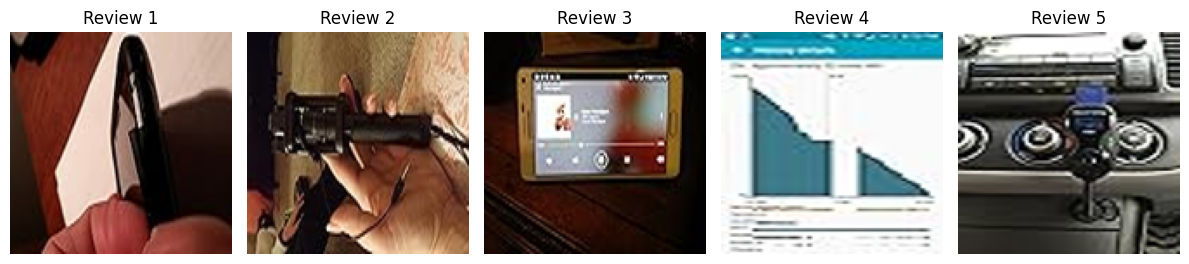

In [17]:
import matplotlib.pyplot as plt

# Number of images to show
N = 5

# Plot the images from the image_array column
plt.figure(figsize=(12, 6))
for i in range(N):
    img_array = df_with_images.iloc[i]['image_array']
    if img_array is not None:
        plt.subplot(1, N, i + 1)
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f"Review {i+1}")
plt.tight_layout()
plt.show()


In [20]:
# Save
df_with_images.to_pickle("dataset_with_images.pkl")

# Load back later
df_loaded = pd.read_pickle("dataset_with_images.pkl")
